In [1]:
# Cell 1: Imports and Dataset Generation with Realistic Channel Modeling
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def modulate(bits, modulation):
    if modulation == 'BPSK':
        return 2 * bits - 1
    elif modulation == 'QPSK':
        symbols = bits.reshape(-1, 2)
        return (2 * symbols[:, 0] - 1) + 1j * (2 * symbols[:, 1] - 1)
    elif modulation == '16QAM':
        symbols = bits.reshape(-1, 4)
        return ((2 * symbols[:, 0] + symbols[:, 1] - 1.5) + 1j * (2 * symbols[:, 2] + symbols[:, 3] - 1.5))
    elif modulation == '32QAM':
        symbols = bits.reshape(-1, 5)
        i = 2 * (2 * symbols[:, 0] + symbols[:, 1]) + symbols[:, 2] - 3.5
        q = 2 * (symbols[:, 3] + 2 * symbols[:, 4]) - 2.5
        return i + 1j * q
    elif modulation == '64QAM':
        symbols = bits.reshape(-1, 6)
        return ((4 * symbols[:, 0] + 2 * symbols[:, 1] + symbols[:, 2] - 3.5) +
                1j * (4 * symbols[:, 3] + 2 * symbols[:, 4] + symbols[:, 5] - 3.5))
    elif modulation == '128QAM':
        symbols = bits.reshape(-1, 7)
        i = (8 * symbols[:, 0] + 4 * symbols[:, 1] + 2 * symbols[:, 2] + symbols[:, 3]) - 7.5
        q = (4 * symbols[:, 4] + 2 * symbols[:, 5] + symbols[:, 6]) - 3.5
        return i + 1j * q
    elif modulation == '256QAM':
        symbols = bits.reshape(-1, 8)
        i = (8 * symbols[:, 0] + 4 * symbols[:, 1] + 2 * symbols[:, 2] + symbols[:, 3]) - 7.5
        q = (8 * symbols[:, 4] + 4 * symbols[:, 5] + 2 * symbols[:, 6] + symbols[:, 7]) - 7.5
        return i + 1j * q
    else:
        raise NotImplementedError(f"{modulation} not supported.")

def awgn(signal, snr_db):
    snr_linear = 10 ** (snr_db / 10)
    power = np.mean(np.abs(signal) ** 2)
    noise_power = power / snr_linear
    noise = np.sqrt(noise_power / 2) * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape))
    return signal + noise

def generate_frame_realistic(modulation, target_egc_snr, num_samples, num_rus):
    bits_per_symbol = {'BPSK': 1, 'QPSK': 2, '16QAM': 4, '32QAM': 5, '64QAM': 6, '128QAM': 7, '256QAM': 8}[modulation]
    bits = np.random.randint(0, 2, num_samples * bits_per_symbol)
    signal = modulate(bits, modulation)

    snr_per_ru = target_egc_snr - 10 * np.log10(num_rus)  # realistic per-RU SNR
    ru_snrs = np.random.normal(loc=snr_per_ru, scale=1.0, size=num_rus)

    frame_data = []
    for snr_db in ru_snrs:
        h = (np.random.randn() + 1j * np.random.randn()) / np.sqrt(2)
        received = h * signal
        noisy = awgn(received, snr_db)
        frame_data.append(noisy)

    return np.stack(frame_data), modulation

def build_dataset(modulations, snrs, num_frames, num_samples, num_rus):
    X, y, snr_labels = [], [], []
    for mod in tqdm(modulations, desc="Generating dataset"):
        for snr in tqdm(snrs, desc=f"{mod}", leave=False):
            for _ in range(num_frames):
                frame, label = generate_frame_realistic(mod, snr, num_samples, num_rus)
                X.append(frame)
                y.append(label)
                snr_labels.append(snr)
    return np.array(X), np.array(y), np.array(snr_labels)

modulations = ['BPSK', 'QPSK', '16QAM', '32QAM', '64QAM', '128QAM', '256QAM']
snr_range = list(range(-10, 32, 2))
num_frames_per_combo = 1024
samples_per_frame = 1024
num_rus = 3

X, y, snrs = build_dataset(modulations, snr_range, num_frames_per_combo, samples_per_frame, num_rus)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_temp, y_train, y_temp, snr_train, snr_temp = train_test_split(X, y_encoded, snrs, train_size=0.75, stratify=y_encoded)
X_val, X_test, y_val, y_test, snr_val, snr_test = train_test_split(X_temp, y_temp, snr_temp, train_size=0.5, stratify=y_temp)

np.savez("modulation_dataset_realistic.npz",
         X_train=X_train, y_train=y_train, snr_train=snr_train,
         X_val=X_val, y_val=y_val, snr_val=snr_val,
         X_test=X_test, y_test=y_test, snr_test=snr_test,
         label_map=le.classes_)


Generating dataset: 100%|██████████| 7/7 [01:29<00:00, 12.78s/it]


In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def equal_gain_combine_realistic(x):
    # Introduce random phase shifts per RU to simulate imperfect alignment
    batch_size, num_rus, num_samples = x.shape
    phases = np.exp(1j * np.random.uniform(0, 2 * np.pi, size=(batch_size, num_rus, 1)))
    x_shifted = x * phases
    combined = np.sum(x_shifted, axis=1)
    return np.stack([combined.real, combined.imag], axis=-1).reshape(batch_size, -1)

# Load data
data = np.load("modulation_dataset_realistic.npz", allow_pickle=True)
label_map = data['label_map']

X_train_egc = equal_gain_combine_realistic(data['X_train'])
X_val_egc = equal_gain_combine_realistic(data['X_val'])
X_test_egc = equal_gain_combine_realistic(data['X_test'])

y_train_cat = tf.keras.utils.to_categorical(data['y_train'])
y_val_cat = tf.keras.utils.to_categorical(data['y_val'])
y_test_cat = tf.keras.utils.to_categorical(data['y_test'])

snr_test = data['snr_test']


2025-06-19 20:07:54.788656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750363675.011578      87 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750363675.073527      87 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from tensorflow.keras import layers, models

def residual_block(x, filters, kernel_size=3):
    shortcut = x
    x = layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_resnet_amc(input_shape, num_classes, num_stacks=5):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(32, kernel_size=3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    for _ in range(num_stacks):
        x = residual_block(x, 32)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs, name="CentralResNet")

# Prepare input shape
input_shape = (X_train_egc.shape[1] // 2, 2)
X_train_central = X_train_egc.reshape(-1, input_shape[0], 2)
X_val_central = X_val_egc.reshape(-1, input_shape[0], 2)
X_test_central = X_test_egc.reshape(-1, input_shape[0], 2)

central_model = build_resnet_amc(input_shape, y_train_cat.shape[1])
central_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]

history_central = central_model.fit(
    X_train_central, y_train_cat,
    validation_data=(X_val_central, y_val_cat),
    epochs=10,
    batch_size=64,
    callbacks=callbacks
)

I0000 00:00:1750363741.290898      87 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/10


I0000 00:00:1750363758.147345     121 service.cc:148] XLA service 0x7c4054002d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750363758.148497     121 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750363759.388598     121 cuda_dnn.cc:529] Loaded cuDNN version 90300


  15/1764 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.1798 - loss: 1.8878

I0000 00:00:1750363762.898453     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1764/1764 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - accuracy: 0.3784 - loss: 1.5096 - val_accuracy: 0.4899 - val_loss: 1.2988
Epoch 2/10
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.5783 - loss: 1.0384 - val_accuracy: 0.6112 - val_loss: 0.9536
Epoch 3/10
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.5904 - loss: 0.9960 - val_accuracy: 0.4727 - val_loss: 1.7569
Epoch 4/10
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.5997 - loss: 0.9785 - val_accuracy: 0.6072 - val_loss: 0.9485
Epoch 5/10
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.6011 - loss: 0.9622 - val_accuracy: 0.5793 - val_loss: 1.0162
Epoch 6/10
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.6126 - loss: 0.9404 - val_accuracy: 0.6309 - val_loss: 0.8995
Epoch 7/10
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.6234 - loss: 0.9102 - val_accuracy: 0.6350 - val_loss: 0.8720
Epoch 8/10
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.6270 - loss: 0.89

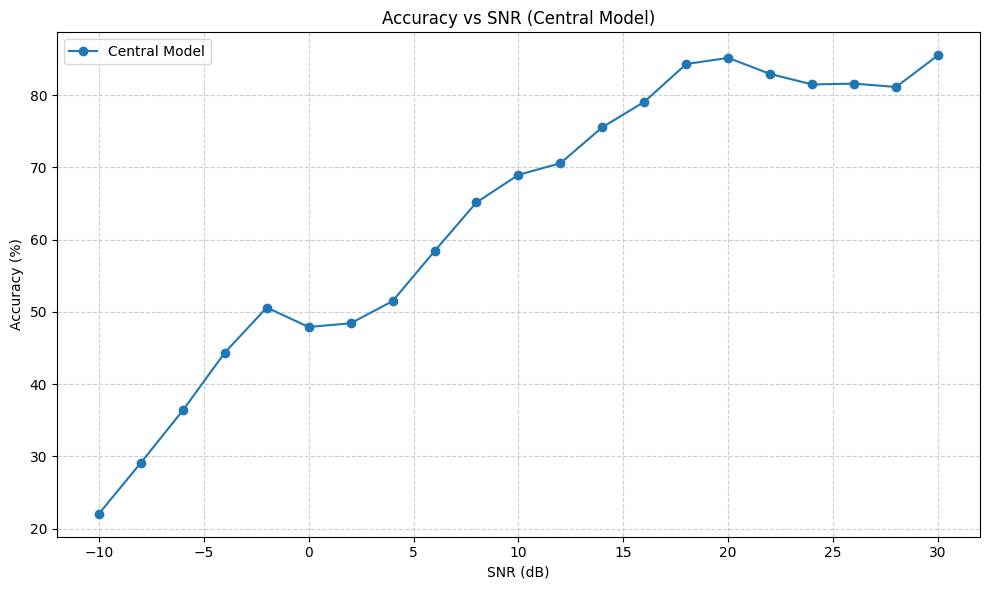

In [3]:
# Cell 4: Evaluation of Central Model per SNR and Accuracy Plot
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def eval_model_per_snr(model, X_test_raw, snr_test, y_test):
    snr_range = sorted(list(set(snr_test)))
    acc_dict = {}
    for snr in snr_range:
        idx = np.where(snr_test == snr)[0]
        X_snr = equal_gain_combine_realistic(X_test_raw[idx]).reshape(-1, input_shape[0], 2)
        y_snr = y_test[idx]
        preds = np.argmax(model.predict(X_snr, verbose=0), axis=1)
        acc = accuracy_score(y_snr, preds)
        acc_dict[snr] = acc * 100
    return acc_dict

acc_central_snr = eval_model_per_snr(central_model, data['X_test'], snr_test, data['y_test'])

# Plot Accuracy vs SNR
snr_range = sorted(list(set(snr_test)))
plt.figure(figsize=(10, 6))
plt.plot(snr_range, [acc_central_snr[s] for s in snr_range], marker='o', label='Central Model')
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs SNR (Central Model)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
modulations = ['BPSK', 'QPSK', '16QAM', '32QAM', '64QAM', '128QAM', '256QAM']
snr_range = list(range(-10, 32, 2))
num_frames_per_combo = 1024
samples_per_frame = 1024
num_rus = 3

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Conv1D, GlobalAveragePooling1D, Dense,
                                     Dropout, BatchNormalization, ReLU, Concatenate)
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# --- Define Parameters ---
samples_per_frame = 1024
num_rus = 3
num_classes = 7  # For example, adjust as per your setup

# --- Assume data is already loaded ---
data = np.load("modulation_dataset_realistic.npz", allow_pickle=True)
X_train_rus = np.transpose(data['X_train'], (0, 2, 1))
X_val_rus = np.transpose(data['X_val'], (0, 2, 1))
X_test_rus = np.transpose(data['X_test'], (0, 2, 1))
y_train_cat = tf.keras.utils.to_categorical(data['y_train'])
y_val_cat = tf.keras.utils.to_categorical(data['y_val'])
y_test = data['y_test']
snr_test = data['snr_test']

# --- Distributed Model ---
def build_ru_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(32, 3, padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv1D(64, 3, padding='same'),
        BatchNormalization(),
        ReLU(),
        GlobalAveragePooling1D(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Combine data from all RUs for training
X_train_ru = np.concatenate([
    X_train_rus[:, :, i].reshape(-1, samples_per_frame, 1)
    for i in range(num_rus)
], axis=0)
X_val_ru = np.concatenate([
    X_val_rus[:, :, i].reshape(-1, samples_per_frame, 1)
    for i in range(num_rus)
], axis=0)
y_train_ru = np.tile(y_train_cat, (num_rus, 1))
y_val_ru = np.tile(y_val_cat, (num_rus, 1))

ru_model = build_ru_model((samples_per_frame, 1), num_classes)
ru_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
ru_model.fit(X_train_ru, y_train_ru, validation_data=(X_val_ru, y_val_ru),
             epochs=8, batch_size=64, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])

def du_voting_predictions(ru_model, X_test_rus):
    predictions = []
    for i in range(num_rus):
        X_ru = X_test_rus[:, :, i].reshape(-1, samples_per_frame, 1)
        preds = ru_model.predict(X_ru, verbose=0)
        predictions.append(preds)
    mean_preds = np.mean(np.stack(predictions, axis=0), axis=0)
    return np.argmax(mean_preds, axis=1), mean_preds

y_pred_distributed, ru_softmax = du_voting_predictions(ru_model, X_test_rus)
acc_distributed = accuracy_score(y_test, y_pred_distributed) * 100
print(f"Overall Distributed Model Accuracy: {acc_distributed:.2f}%")

Epoch 1/8
5292/5292 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - accuracy: 0.2673 - loss: 1.7525 - val_accuracy: 0.3538 - val_loss: 1.6539
Epoch 2/8
5292/5292 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.3559 - loss: 1.6378 - val_accuracy: 0.3918 - val_loss: 1.5294
Epoch 3/8
5292/5292 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.3847 - loss: 1.5377 - val_accuracy: 0.4041 - val_loss: 1.4767
Epoch 4/8
5292/5292 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.3934 - loss: 1.4964 - val_accuracy: 0.4011 - val_loss: 1.4559
Epoch 5/8
5292/5292 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.3973 - loss: 1.4726 - val_accuracy: 0.3583 - val_loss: 1.4846
Epoch 6/8
5292/5292 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.3990 - loss: 1.4601 - val_accuracy: 0.4106 - val_loss: 1.4338
Epoch 7/8
5292/5292 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.4029 - loss: 1.4522 - val_accuracy: 0.4126 - val_loss: 1.4189
Epoch 8/8
5292/5292 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.4037 - loss: 1.4405 - 

In [8]:
# Prepare hybrid input (EGC + Distributed softmax)
ru_train_softmax = np.mean(np.stack([
    ru_model.predict(X_train_rus[:, :, i].reshape(-1, samples_per_frame, 1), verbose=0)
    for i in range(num_rus)
], axis=0), axis=0)

ru_val_softmax = np.mean(np.stack([
    ru_model.predict(X_val_rus[:, :, i].reshape(-1, samples_per_frame, 1), verbose=0)
    for i in range(num_rus)
], axis=0), axis=0)

# Build Hybrid Model
input_egc = Input(shape=(X_train_egc.shape[1],))
x1 = Dense(256, activation='relu')(input_egc)
x1 = Dropout(0.3)(x1)

input_ru = Input(shape=(num_classes,))
x2 = Dense(64, activation='relu')(input_ru)

merged = Concatenate()([x1, x2])
x = Dense(128, activation='relu')(merged)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

hybrid_model = Model(inputs=[input_egc, input_ru], outputs=output)
hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train hybrid model
hybrid_model.fit([X_train_egc, ru_train_softmax], y_train_cat,
                 validation_data=([X_val_egc, ru_val_softmax], y_val_cat),
                 epochs=15, batch_size=64,
                 callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])

# Prepare test inputs and evaluate
ru_test_softmax = np.mean(np.stack([
    ru_model.predict(X_test_rus[:, :, i].reshape(-1, samples_per_frame, 1), verbose=0)
    for i in range(num_rus)
], axis=0), axis=0)

X_test_hybrid = [X_test_egc, ru_test_softmax]
y_pred_hybrid = np.argmax(hybrid_model.predict(X_test_hybrid, verbose=0), axis=1)
acc_hybrid = accuracy_score(y_test, y_pred_hybrid) * 100
print(f"Overall Hybrid Model Accuracy: {acc_hybrid:.2f}%")


Epoch 1/15
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.2640 - loss: 2.9762 - val_accuracy: 0.4794 - val_loss: 1.2474
Epoch 2/15
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4612 - loss: 1.2667 - val_accuracy: 0.5084 - val_loss: 1.1311
Epoch 3/15
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4918 - loss: 1.1780 - val_accuracy: 0.5064 - val_loss: 1.1296
Epoch 4/15
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4965 - loss: 1.1555 - val_accuracy: 0.4988 - val_loss: 1.1216
Epoch 5/15
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5010 - loss: 1.1411 - val_accuracy: 0.4901 - val_loss: 1.1281
Epoch 6/15
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5051 - loss: 1.1274 - val_accuracy: 0.5108 - val_loss: 1.1270
Epoch 7/15
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5084 - loss: 1.1150 - val_accuracy: 0.4921 - val_loss: 1.1338
Overall Hybrid Model Accuracy: 49.41%


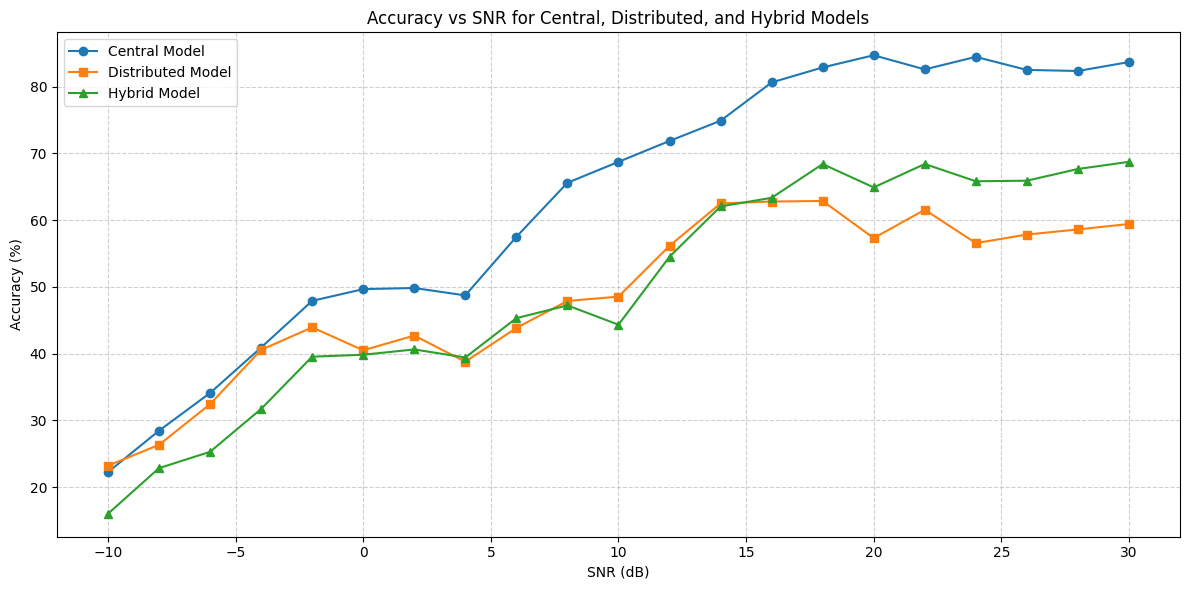

In [9]:
# --- Central Model Accuracy per SNR ---
acc_central_snr = eval_model_per_snr(central_model, data['X_test'], snr_test, y_test)

# --- Distributed Model Accuracy per SNR ---
acc_distributed_snr = {}
y_test_arr = np.array(y_test)
for snr in sorted(set(snr_test)):
    idx = np.where(snr_test == snr)[0]
    preds = np.argmax(np.mean(np.stack([
        ru_model.predict(X_test_rus[idx, :, i].reshape(-1, samples_per_frame, 1), verbose=0)
        for i in range(num_rus)
    ], axis=0), axis=0), axis=1)
    acc = accuracy_score(y_test_arr[idx], preds)
    acc_distributed_snr[snr] = acc * 100

# --- Hybrid Model Accuracy per SNR ---
acc_hybrid_snr = {}
for snr in sorted(set(snr_test)):
    idx = np.where(snr_test == snr)[0]
    X_egc = X_test_egc[idx]
    ru_softmax_local = np.mean(np.stack([
        ru_model.predict(X_test_rus[idx, :, i].reshape(-1, samples_per_frame, 1), verbose=0)
        for i in range(num_rus)
    ], axis=0), axis=0)
    preds = np.argmax(hybrid_model.predict([X_egc, ru_softmax_local], verbose=0), axis=1)
    acc = accuracy_score(y_test_arr[idx], preds)
    acc_hybrid_snr[snr] = acc * 100

# --- Plot Accuracy vs SNR for all 3 models ---
snr_list = sorted(set(snr_test))

plt.figure(figsize=(12, 6))
plt.plot(snr_list, [acc_central_snr[s] for s in snr_list], marker='o', label='Central Model')
plt.plot(snr_list, [acc_distributed_snr[s] for s in snr_list], marker='s', label='Distributed Model')
plt.plot(snr_list, [acc_hybrid_snr[s] for s in snr_list], marker='^', label='Hybrid Model')

plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs SNR for Central, Distributed, and Hybrid Models")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
